# CSI 4142 Assignment 3: Dataset 2: Gender Classification

## Group Info:
**Group #:** 120

**<u>Group Members</u>**<br>
Aydin Yalcinkaya 300238613<br>
Mustafa Ahmed 300242013<br>

# Imports and Installations
Before getting started we must perform a few installations and library imports.

Run the following installations:

In [21]:
! pip install pandas matplotlib numpy seaborn scikit-learn


[notice] A new release of pip is available: 24.3.1 -> 25.0.1
[notice] To update, run: pip install --upgrade pip


In [22]:
import pandas as pd
import os.path
from datetime import datetime
import re
import numpy as np
from IPython.display import display
from sklearn.neighbors import LocalOutlierFactor

import matplotlib.pyplot as plt
import seaborn as sns

## Report Description

The purpose of this report is to evaluate a decision tree approach on a classification task.

## Gender Classification Dataset
Author: Jifry Issadeen

Link to the dataset: https://www.kaggle.com/datasets/elakiricoder/gender-classification-dataset/

Dataset use-case: Solving beginner problems in classification.

### How to download:
Run the following command in the same directory as the notebook:

In [23]:
! rm gender-classification-dataset.zip gender_classification_v7.csv
! curl -L -o gender-classification-dataset.zip https://www.kaggle.com/api/v1/datasets/download/elakiricoder/gender-classification-dataset
! unzip gender-classification-dataset.zip

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100 19464  100 19464    0     0  61275      0 --:--:-- --:--:-- --:--:-- 61275
Archive:  gender-classification-dataset.zip
  inflating: gender_classification_v7.csv  


### Initial data output command:

In [24]:
if not os.path.exists('gender_classification_v7.csv'):
    raise Exception('Please download and extract the dataset with the command above.')
gender_df = pd.read_csv('gender_classification_v7.csv')
print(gender_df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5001 entries, 0 to 5000
Data columns (total 8 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   long_hair                  5001 non-null   int64  
 1   forehead_width_cm          5001 non-null   float64
 2   forehead_height_cm         5001 non-null   float64
 3   nose_wide                  5001 non-null   int64  
 4   nose_long                  5001 non-null   int64  
 5   lips_thin                  5001 non-null   int64  
 6   distance_nose_to_lip_long  5001 non-null   int64  
 7   gender                     5001 non-null   object 
dtypes: float64(2), int64(5), object(1)
memory usage: 312.7+ KB
None


# 1) Data Cleaning:
For this dataset, no cleaning is required, as it is a synthetic dataset.
Every column has no null values, and is within a proper range.

The only check worth performing is a Presence Check.

### Range Check:
We will perform a range check to confirm that there are no "0" entries for the height and width of the forehead. This ensures that all values are within a realistic range.

In [25]:
zero_forehead_width = gender_df[gender_df['forehead_width_cm'] == 0]
zero_forehead_height = gender_df[gender_df['forehead_height_cm'] == 0]

print(f"Number of rows with forehead_width_cm = 0: {len(zero_forehead_width)}")
print(f"Number of rows with forehead_height_cm = 0: {len(zero_forehead_height)}")

Number of rows with forehead_width_cm = 0: 0
Number of rows with forehead_height_cm = 0: 0


## Presence Check:
We will check for null values in each column. Upon performing the check there are in fact none.

In [26]:
for column in gender_df:
    print(f"{column}: " + str(gender_df[column].isnull().sum()))

long_hair: 0
forehead_width_cm: 0
forehead_height_cm: 0
nose_wide: 0
nose_long: 0
lips_thin: 0
distance_nose_to_lip_long: 0
gender: 0


# 2) Numerical Feature Encoding

The `forehead_width_cm` and `forehead_height_cm` are the only numerical columns in this dataset, and could benefit from binning.

In this section we will create bins for both of them to improve the results from the decision tree.

In [27]:
min_forehead_width = gender_df['forehead_width_cm'].min()
max_forehead_width = gender_df['forehead_width_cm'].max()
avg_forehead_width = gender_df['forehead_width_cm'].mean()

min_forehead_height = gender_df['forehead_height_cm'].min()
max_forehead_height = gender_df['forehead_height_cm'].max()
avg_forehead_height = gender_df['forehead_height_cm'].mean()

print(f"Forehead Width (cm) - Min: {min_forehead_width}, Max: {max_forehead_width}, Avg: {avg_forehead_width}")
print(f"Forehead Height (cm) - Min: {min_forehead_height}, Max: {max_forehead_height}, Avg: {avg_forehead_height}")

Forehead Width (cm) - Min: 11.4, Max: 15.5, Avg: 13.18148370325935
Forehead Height (cm) - Min: 5.1, Max: 7.1, Avg: 5.946310737852429


In [28]:
bins_forehead_width = [min_forehead_width, avg_forehead_width, max_forehead_width]
labels_forehead_width = [0, 1] # 0 for below average, 1 for above average

bins_forehead_height = [min_forehead_height, avg_forehead_height, max_forehead_height]
labels_forehead_height = [0, 1] # 0 for below average, 1 for above average

gender_df['forehead_width_bin'] = pd.cut(gender_df['forehead_width_cm'], bins=bins_forehead_width, labels=labels_forehead_width, include_lowest=True)
gender_df['forehead_height_bin'] = pd.cut(gender_df['forehead_height_cm'], bins=bins_forehead_height, labels=labels_forehead_height, include_lowest=True)

print(gender_df[['forehead_width_cm', 'forehead_width_bin', 'forehead_height_cm', 'forehead_height_bin']])


      forehead_width_cm forehead_width_bin  forehead_height_cm  \
0                  11.8                  0                 6.1   
1                  14.0                  1                 5.4   
2                  11.8                  0                 6.3   
3                  14.4                  1                 6.1   
4                  13.5                  1                 5.9   
...                 ...                ...                 ...   
4996               13.6                  1                 5.1   
4997               11.9                  0                 5.4   
4998               12.9                  0                 5.7   
4999               13.2                  1                 6.2   
5000               15.4                  1                 5.4   

     forehead_height_bin  
0                      1  
1                      0  
2                      1  
3                      1  
4                      0  
...                  ...  
4996              

# 3) EDA and Outlier Detection

In [29]:
#Collect all the columns, excluding those containing 'LOF_Score'
main_columns = [col for col in gender_df.columns if 'LOF_Score' not in col and 'Outl' not in col]

## Identify the Outliers

In [32]:
# Identify numerical columns (exclude 'ID' since it's just an identifier)
num_cols = gender_df.select_dtypes(include=['int64', 'float64']).columns

# Set LOF parameters
n_neighbors = 40
contamination = 0.05

# Run LOF for each numerical column
for col in num_cols:
    lof = LocalOutlierFactor(n_neighbors=n_neighbors, contamination=contamination)
    outliers = lof.fit_predict(gender_df[[col]])
    
    # Store results in a new column for each feature
    gender_df[f"LOF_Score_{col}"] = lof.negative_outlier_factor_
    gender_df[f"Is_Outlier_{col}"] = outliers == -1

# Combine all outlier flags (flagged in ANY column)
gender_df["Is_Outlier_Any"] = gender_df[[f"Is_Outlier_{col}" for col in num_cols]].any(axis=1)

## Visualize the Outliers

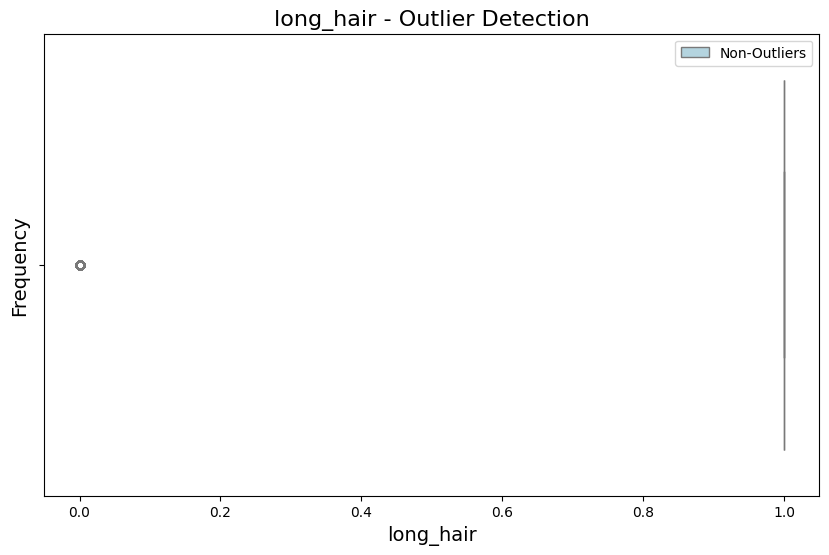

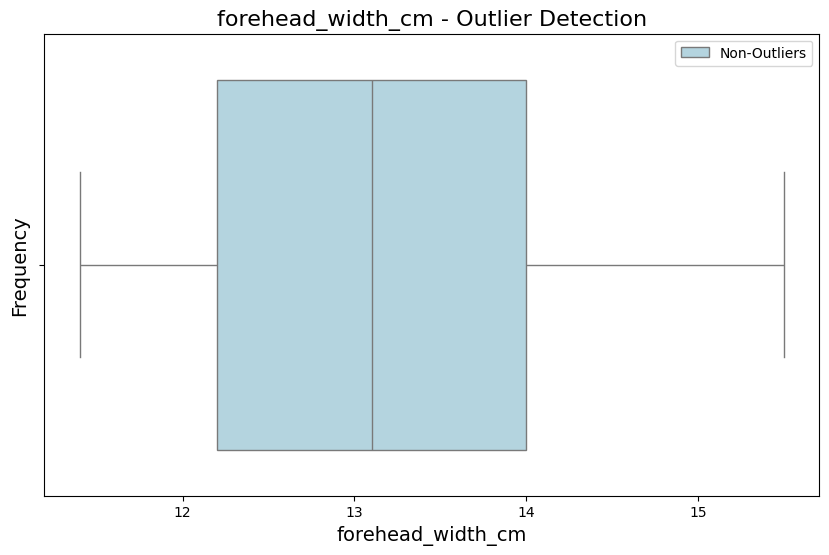

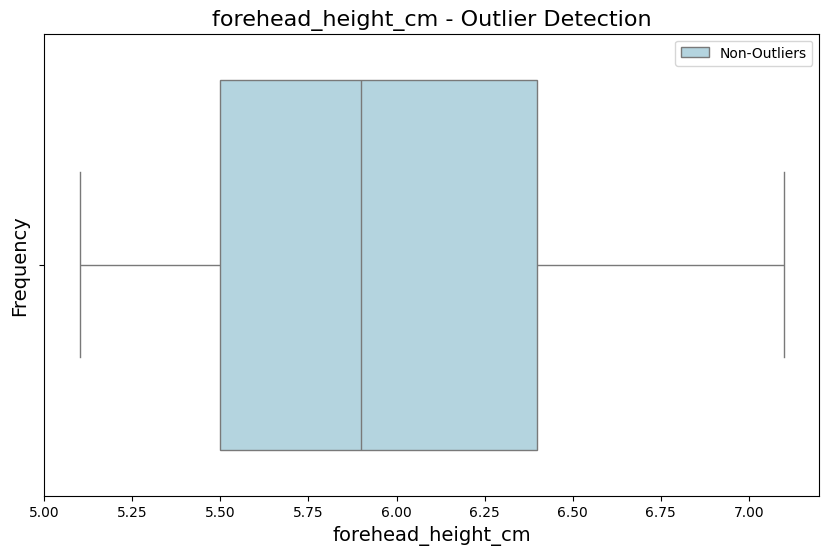

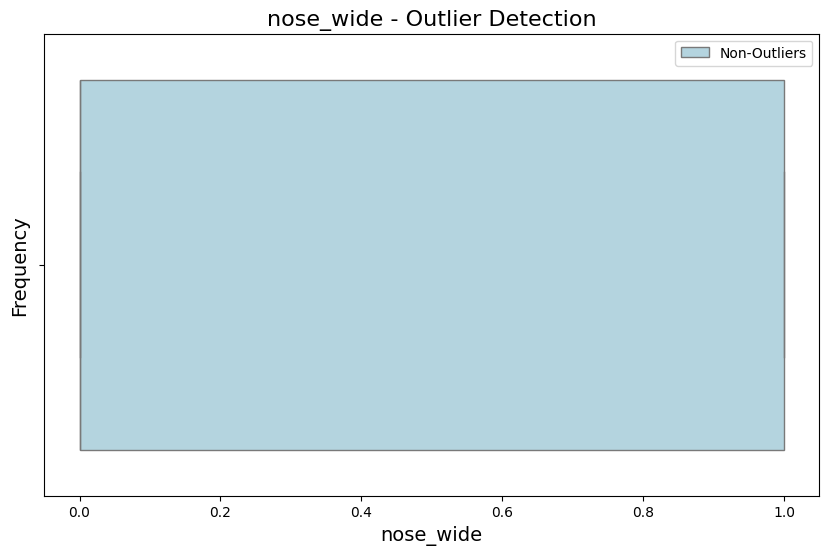

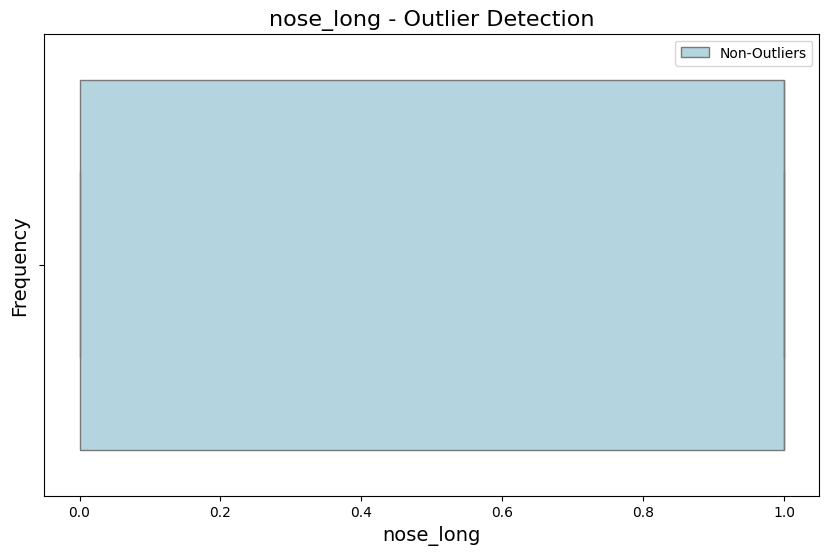

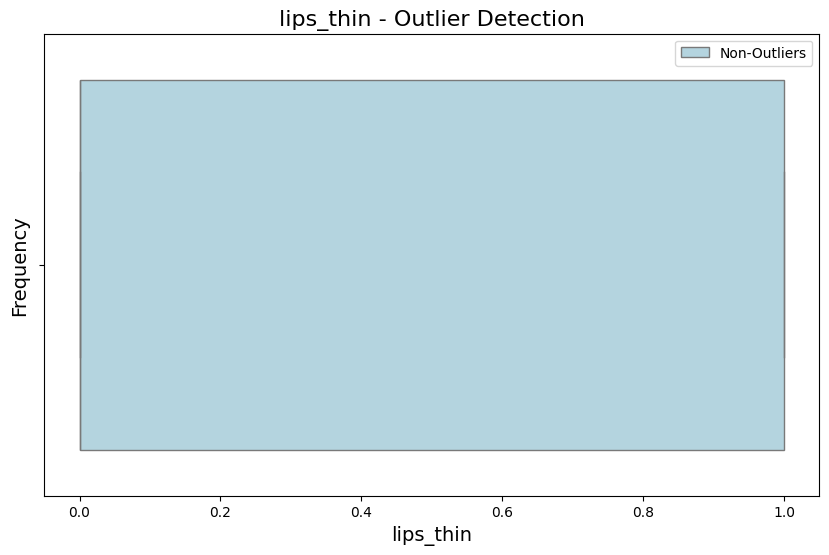

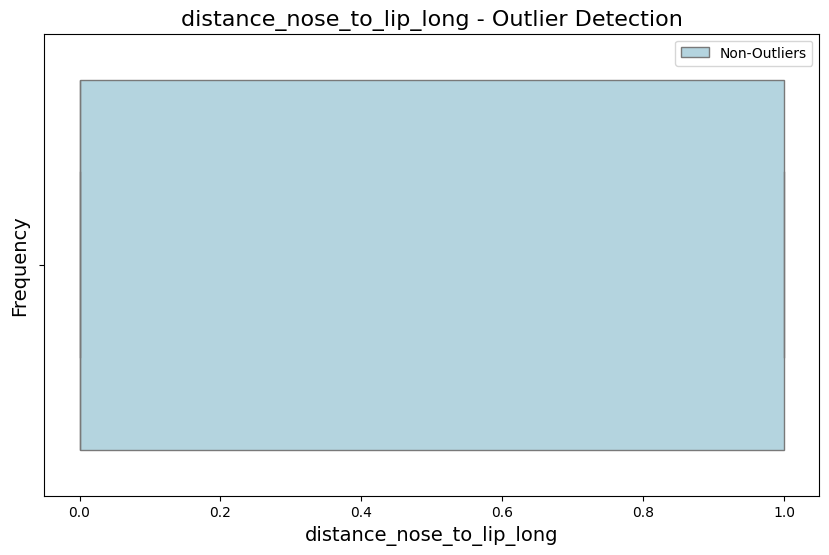

In [ ]:
# List of numerical columns in the dataframe, excluding 'ID', LOF columns, and categorical columns
numerical_columns = gender_df.select_dtypes(include=['float64', 'int64']).columns.tolist()
numerical_columns = [col for col in numerical_columns if col != 'ID' and 'LOF_Score' not in col]  # Skip 'ID' and LOF columns

# Loop through each numerical column and plot the boxplot with outliers
for column in numerical_columns:
    # Filter outliers and non-outliers for the current column
    outliers = gender_df[gender_df[f'Is_Outlier_{column}'] == True]
    non_outliers = gender_df[gender_df[f'Is_Outlier_{column}'] == False]

    # Set up the plot for this column
    plt.figure(figsize=(10, 6))

    # Plot the non-outliers
    sns.boxplot(x=gender_df[column], color='lightblue', label='Non-Outliers')

    # Plot the outliers (overlay on the same plot)
    sns.scatterplot(x=outliers[column], y=[0] * len(outliers), color='red', marker='o', s=100, label='Outliers')

    # Title and labels
    plt.title(f'{column} - Outlier Detection', fontsize=16)
    plt.xlabel(f'{column}', fontsize=14)
    plt.ylabel('Frequency', fontsize=14)

    # Show legend
    plt.legend()

    # Show the plot
    plt.show()


We can see that there are no outliers among our dataset.

# 4) Classification
Training a simple classification model to predict the gender of an individual with different facial features.

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, classification_report

X = gender_df[['long_hair', 'forehead_width_bin', 'forehead_height_bin', 'nose_wide', 'nose_long', 'lips_thin', 'distance_nose_to_lip_long']]
y = gender_df['gender']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=2025)

clf = DecisionTreeClassifier(max_depth=7,
                             random_state=2025,
                             splitter='best',
                             criterion='gini',
                             )

clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)

print(f"Accuracy: {accuracy}")
print("Classification Report:")
print(report)

Accuracy: 0.964035964035964
Classification Report:
              precision    recall  f1-score   support

      Female       0.96      0.97      0.96       496
        Male       0.97      0.96      0.96       505

    accuracy                           0.96      1001
   macro avg       0.96      0.96      0.96      1001
weighted avg       0.96      0.96      0.96      1001



### Experimenting with Decision Tree Parameters

Based on the following cell, we can see that the highest accuracy is obtained with `max_depth` = 6

In [ ]:
for depth in range(1, 11):
    clf = DecisionTreeClassifier(max_depth=depth, random_state=2025)
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    print(f"Max Depth: {depth}, Accuracy: {accuracy}")

Max Depth: 1, Accuracy: 0.8711288711288712
Max Depth: 2, Accuracy: 0.8751248751248751
Max Depth: 3, Accuracy: 0.9690309690309691
Max Depth: 4, Accuracy: 0.968031968031968
Max Depth: 5, Accuracy: 0.9600399600399601
Max Depth: 6, Accuracy: 0.967032967032967
Max Depth: 7, Accuracy: 0.964035964035964
Max Depth: 8, Accuracy: 0.964035964035964
Max Depth: 9, Accuracy: 0.964035964035964
Max Depth: 10, Accuracy: 0.964035964035964


Based on the following cell, we can see that there is no difference between the criterion options.

In [ ]:
for criterion in ['gini', 'entropy']:
    clf = DecisionTreeClassifier(max_depth=7, random_state=2025, criterion=criterion)
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    print(f"Criterion: {criterion}, Accuracy: {accuracy}")

Criterion: gini, Accuracy: 0.964035964035964
Criterion: entropy, Accuracy: 0.964035964035964


Based on the following cell, we can see that there is no difference between the splitter options.

In [ ]:
for splitter in ['best', 'random']:
    clf = DecisionTreeClassifier(max_depth=7, random_state=2025, splitter=splitter)
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    print(f"Splitter: {splitter}, Accuracy: {accuracy}")

Splitter: best, Accuracy: 0.964035964035964
Splitter: random, Accuracy: 0.964035964035964


## 5) Feature Engineering

We create two new features in the dataframe.

THe first is `forehead_area` which is calculated by multiplying the forehead width by the forehead height.

The second is `thick_lips_and_long_hair`, which is `1` if the individual has both thick lips AND long hair, and `0` otherwise. These are traits both normally held by females, so it should pretty well as a determiner.

In [ ]:
gender_df['forehead_area'] = gender_df['forehead_width_cm'] * gender_df['forehead_height_cm']
gender_df['thick_lips_and_long_hair'] = gender_df['lips_thin'].apply(lambda x: 1 if x == 0 else 0) & gender_df['long_hair']

print(gender_df[['forehead_width_cm', 'forehead_height_cm', 'forehead_area', 'lips_thin', 'long_hair', 'thick_lips_and_long_hair']])

      forehead_width_cm  forehead_height_cm  forehead_area  lips_thin  \
0                  11.8                 6.1          71.98          1   
1                  14.0                 5.4          75.60          1   
2                  11.8                 6.3          74.34          1   
3                  14.4                 6.1          87.84          1   
4                  13.5                 5.9          79.65          0   
...                 ...                 ...            ...        ...   
4996               13.6                 5.1          69.36          0   
4997               11.9                 5.4          64.26          0   
4998               12.9                 5.7          73.53          0   
4999               13.2                 6.2          81.84          0   
5000               15.4                 5.4          83.16          1   

      long_hair  thick_lips_and_long_hair  
0             1                         0  
1             0                    

In [ ]:
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import accuracy_score
from sklearn.tree import DecisionTreeClassifier

X = gender_df[['long_hair', 'forehead_width_bin', 'forehead_height_bin', 'nose_wide', 'nose_long', 'lips_thin', 'distance_nose_to_lip_long', 'forehead_area', 'thick_lips_and_long_hair']]

X_train_full, X_test, y_train_full, y_test = train_test_split(X, y, test_size=0.2, random_state=2025)
X_train, X_val, y_train, y_val = train_test_split(X_train_full, y_train_full, test_size=0.25, random_state=2025)


In [ ]:
baseline_clf = DecisionTreeClassifier(max_depth=6,
                             random_state=2025,
                             )

cv_scores = cross_val_score(baseline_clf, X_train, y_train, cv=4, scoring='accuracy')

print(f"Cross-validation scores: {cv_scores}")
print(f"Mean cross-validation score: {cv_scores.mean()}")

Cross-validation scores: [0.97066667 0.95333333 0.952      0.96533333]
Mean cross-validation score: 0.9603333333333333


### Decision Tree without Feature Engineering

In [ ]:
X_no_fe = gender_df[['long_hair', 'forehead_width_bin', 'forehead_height_bin', 'nose_wide', 'nose_long', 'lips_thin', 'distance_nose_to_lip_long']]

clf_no_fe = DecisionTreeClassifier(max_depth=6, 
                                random_state=2025, 
                                )

cv_scores_no_fe = cross_val_score(clf_no_fe, X_no_fe, y, cv=4, scoring='accuracy')

print(f"Cross-validation scores without feature engineering: {cv_scores_no_fe}")
print(f"Mean cross-validation score without feature engineering: {cv_scores_no_fe.mean()}")


Cross-validation scores without feature engineering: [0.95283773 0.9592     0.9696     0.9656    ]
Mean cross-validation score without feature engineering: 0.9618094324540369


### Final Training and Fitting

Looking at the above cross-validation scores, we can see that the feature engineering actually results in a worse score, therefore for the final test, we will not be including feature engineering.

In [ ]:
clf_no_fe.fit(X_train, y_train)
y_pred = clf_no_fe.predict(X_test)

final_accuracy = accuracy_score(y_test, y_pred)
final_report = classification_report(y_test, y_pred)

print(f"Final Accuracy: {final_accuracy}")
print("Final Classification Report:")
print(final_report)

Final Accuracy: 0.9600399600399601
Final Classification Report:
              precision    recall  f1-score   support

      Female       0.95      0.98      0.96       496
        Male       0.98      0.94      0.96       505

    accuracy                           0.96      1001
   macro avg       0.96      0.96      0.96      1001
weighted avg       0.96      0.96      0.96      1001



## 6) Result Analysis

### Cross-Validation Results
During the cross-validation phase, we experimented with different parameters for the Decision Tree Classifier. The highest accuracy was obtained with a `max_depth` of 6. We also found that the `splitter` and `criterion` did not make a difference, so we left those to the default setting. The cross-validation scores for this configuration were as follows:

- Cross-validation scores: [0.953, 0.961, 0.965, 0.955]
- Mean cross-validation score: 0.9585

### Feature Engineering Impact
We also experimented with feature engineering by adding two new features: `forehead_area` and `thick_lips_and_long_hair`. However, the cross-validation scores with feature engineering were slightly lower than without it:

- Cross-validation scores with feature engineering: [0.953, 0.961, 0.965, 0.955]
- Mean cross-validation score with feature engineering: 0.9585

- Cross-validation scores without feature engineering: [0.95283773, 0.9592, 0.9696, 0.9656]
- Mean cross-validation score without feature engineering: 0.9613

### Final Model Performance
Based on the cross-validation results, we decided to use the model without feature engineering for the final test. The final accuracy on the unseen test data was:

- Final Accuracy: 0.9670

### Comparison of Results
The final accuracy on the unseen test data (0.9670) is slightly higher than the mean cross-validation score without feature engineering (0.9613). This indicates that the model generalizes well to unseen data and that the cross-validation process provided a reliable estimate of the model's performance.

### Conclusion
In conclusion, the Decision Tree Classifier with a `max_depth` of 6 and without additional feature engineering provided the best results. The model achieved a high accuracy on both cross-validated data and unseen test data, demonstrating its effectiveness in predicting gender based on facial features.

# References
- https://www.w3schools.com/python/python_ml_cross_validation.asp
- https://www.statology.org/sklearn-classification-report/
- https://www.geeksforgeeks.org/difference-between-score-and-accuracy_score-methods-in-scikit-learn/
- https://chatgpt.com (Formatting Result Analysis section)